# This is pretty important
# Please read
# Or you will regret it
In some places, I have divided the values of epsilon by 2 to get consistent plots for the presentation.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import skimage.data as data

from skimage.data import shepp_logan_phantom
from skimage.filters import *
from skimage.transform import radon, iradon, resize

from time import time, sleep

random_generator = np.random.default_rng()

matplotlib.rc('image', cmap='gray')

In [2]:
def get_mask(r = 1):
    x = y = np.arange(nx)
    xx, yy = np.meshgrid(x, y)
    
    return ((xx - nx/2)**2 + (yy - nx/2)**2 < (r * nx/2)**2).astype(float)

def get_image():
    u = 0.5 * np.float64(data.binary_blobs(length=nx, blob_size_fraction=0.5))
    u += 0.5 * np.float64(data.binary_blobs(length=nx, blob_size_fraction=0.2))
   
    mask = get_mask(r=0.9)
    u *= mask
   
    return u

nx = 200

image = get_image()
theta = np.linspace(0., 180., max(image.shape), endpoint=False)


# Function definitions used throughout the Notebook

In [3]:
def add_sinogram_noise(sinogram, I_0):
    I = random_generator.poisson(I_0 * np.exp(-sinogram))
    return -np.log(I / I_0)
    
    # Alternatively, we could approximate the Poisson distribution
    # by a Gaussian distribution. This gives more or less the same
    # result.
    # sinogram = random_generator.normal(
    #     sinogram, 1/ np.sqrt((I_0 * np.exp(-sinogram))))
    
def show_sinogram(ax, title_str, sinogram):
    ax.set_title(title_str)
    
    ax.set_xlabel("Projection angle (deg)")
    ax.set_ylabel("Projection position (pixels)")
    img_sinogram = ax.imshow(sinogram, 
                             aspect='auto')
    plt.colorbar(img_sinogram, ax=ax, fraction=0.046, pad=0.04)

def show_image(ax, title_str, image):
    ax.set_title(title_str)
    img = ax.imshow(image, aspect='auto', 
                    vmin=-0.005, vmax=0.01
                   )
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)    
    
def show_transformed_sinogram(ax, title_str, transformed_sinogram):
    ax.set_title(f"{title_str} Fourier Transform")
    
    ax.set_xlabel("Projection angle (deg)")
    ax.set_ylabel("Frequency (probably wrong units)")
    transformed_img = ax.imshow(abs(transformed_sinogram), aspect='auto')
    plt.colorbar(transformed_img, ax=ax, fraction=0.046, pad=0.04)

In [4]:
from torch.utils.data import Dataset

class NumpyArrayDataset(Dataset):
    def __init__(self, path):
        self.npzfile = np.load(path)
        self.img_shape = self.npzfile[self.npzfile.files[0]][0].shape
    
    def __getitem__(self, idx):
        img = self.npzfile[self.npzfile.files[idx]].astype(np.single)
    
        entry = self.npzfile[self.npzfile.files[idx]]
    
        # For compatibility with the convolutional layers in the
        # network, we need to reshape the image to make it explicit 
        # that the image consists of one layer. 
        noisy_image = np.reshape(entry[0], (1, *self.img_shape))
        true_image  = np.reshape(entry[2], (1, *self.img_shape))
    
        # entry[0] is the noisy image, entry[1] is the true image. The
        # goal will be for the network to learn the mapping
        # noisy --> true.
        return (noisy_image.astype(np.single), true_image.astype(np.single))
    
    def __len__(self):
        return len(self.npzfile)
    
path = 'shapes-dataset-various-noise-levels.npz'
shape_dataset = shapes_dataset = NumpyArrayDataset(path)

# Some information about the dataset

In [5]:
min_value = np.inf
max_value = 0
norm_sum = 0
    
for shape, _ in zip(shape_dataset, range(16)):
    min_value = min(min_value, shape[0][0].min())
    max_value = max(max_value, shape[0][0].max())
    norm_sum += np.linalg.norm(shape[0][0])

mean_norm = norm_sum / 16
    
print("Minimum pixel intensity: ", min_value)
print("Maximum pixel intensity: ", max_value)
print("Mean norm: ", mean_norm)

Minimum pixel intensity:  -0.00052973075
Maximum pixel intensity:  0.010478739
Mean norm:  0.15757048642262816


## Filter definitions

In [6]:
# Ramp filter. eps is not used.
def G_ramp(w, eps=0):
    return abs(w)

# Rectangle filter
def G_ram_lak(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w

# Truncated cosine
def G_cosine_t(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.cos(np.pi * w / 2)

# Scaled cosine
def G_cosine_s(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.cos(np.pi * w / (2 * eps))

# Truncated Shepp-Logan filter
def G_shepp_logan_t(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.sinc(w)

# Scaled Shepp-Logan
def G_shepp_logan_s(w, eps):
    w = abs(w)
    w[w > eps] = 0
    return w * np.sinc(w / eps)

# Plotting different filters - Ramp, Ram-Lak, etc.

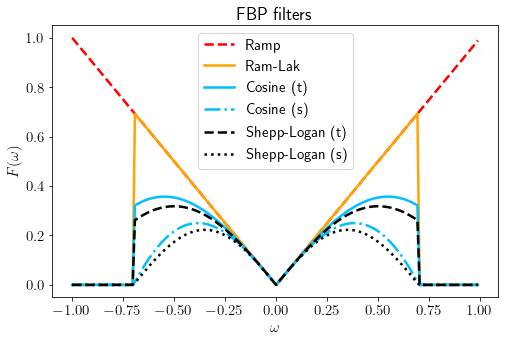

In [10]:
plt.figure(figsize=(8, 5))

plt.rcParams.update({"text.usetex": True, "font.size": 15})

ws = np.fft.fftshift(2 * np.fft.fftfreq(sinogram.shape[0]))
eps = 0.7

filter_list = [G_ramp, G_ram_lak, G_cosine_t, G_cosine_s, G_shepp_logan_t, G_shepp_logan_s]
name_list = ['Ramp', 'Ram-Lak', 'Cosine (t)', 'Cosine (s)', 'Shepp-Logan (t)', 'Shepp-Logan (s)']
color_list = ['red', 'orange', 'deepskyblue', 'deepskyblue', 'black', 'black']
style_list = ['dashed', 'solid', 'solid', 'dashdot', 'dashed', 'dotted']

for G, name, color, style in zip(filter_list, name_list, color_list, style_list):
    fs = G(ws, eps)
    plt.plot(ws, fs, label=name, c=color, ls=style, lw=2.5)
    
plt.legend()
plt.title('FBP filters')
plt.xlabel('$\omega$')
plt.ylabel('$F(\omega)$')
plt.savefig('low-pass-filtered-ramp.png')

/tmp/ipykernel_5357/3339980777.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ws / 2, fs / abs(ws), label=name, c=color, ls=style, lw=2.5)
/tmp/ipykernel_5357/3339980777.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ws / 2, fs / abs(ws), label=name, c=color, ls=style, lw=2.5)
/tmp/ipykernel_5357/3339980777.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ws / 2, fs / abs(ws), label=name, c=color, ls=style, lw=2.5)
/tmp/ipykernel_5357/3339980777.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ws / 2, fs / abs(ws), label=name, c=color, ls=style, lw=2.5)
/tmp/ipykernel_5357/3339980777.py:18: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ws / 2, fs / abs(ws), label=name, c=color, ls=style, lw=2.5)


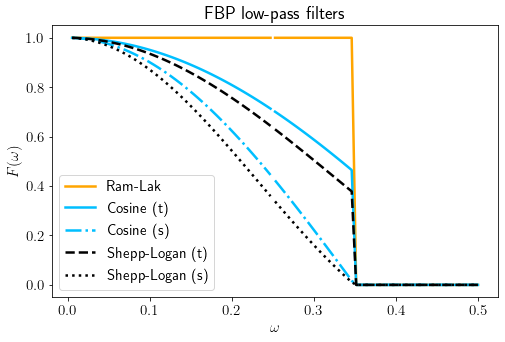

In [11]:
plt.figure(figsize=(8, 5))

plt.rcParams.update({"text.usetex": True, "font.size": 15})

ws = np.fft.fftshift(2 * np.fft.rfftfreq(sinogram.shape[0]))
eps = 0.7

filter_list = [G_ramp, G_ram_lak, G_cosine_t, G_cosine_s, G_shepp_logan_t, G_shepp_logan_s]
name_list = ['Ramp', 'Ram-Lak', 'Cosine (t)', 'Cosine (s)', 'Shepp-Logan (t)', 'Shepp-Logan (s)']
color_list = ['red', 'orange', 'deepskyblue', 'deepskyblue', 'black', 'black']
style_list = ['dashed', 'solid', 'solid', 'dashdot', 'dashed', 'dotted']

for G, name, color, style in zip(filter_list, name_list, color_list, style_list):
    if name == 'Ramp':
        continue
        
    fs = G(ws, eps)
    plt.plot(ws / 2, fs / abs(ws), label=name, c=color, ls=style, lw=2.5)
    
plt.legend()
plt.title('FBP low-pass filters')
plt.xlabel('$\omega$')
plt.ylabel('$F(\omega)$')
plt.savefig('low-pass-filters.png')

# Running the full process once - Radon, Filter, Back-Projection
Results from this cell are used in several places to avoid having to compute the same thing over and over.

In [9]:
noisy = False
title_str = "Noisy" if noisy else "Normal"

# The original image.

# img = 0.01 * get_mask(r=0.5)

img = resize(0.01 * shepp_logan_phantom(), (128, 128))
# img = shape_dataset[7][0][0]

# Perform the Radon Transformation
theta = np.linspace(0, 180, max(img.shape), endpoint=False)
sinogram = radon(img, theta=theta, circle=False)

# Add noise if necessary
if noisy: 
    sinogram = add_sinogram_noise(sinogram, I_0=100)

# Compute the Fourier Transform of the sinogram
transformed_sinogram = np.fft.fft(sinogram, axis=0)

# Apply the Ramp filter
filtered_transformed_sinogram = transformed_sinogram.copy()

height, width = filtered_transformed_sinogram.shape
for i in range(width):
    filtered_transformed_sinogram[:, i] *= 2 * G_ram_lak(np.fft.fftfreq(sinogram.shape[0]), 2)

# Back to the sensor domain
filtered_sinogram = np.fft.ifft(filtered_transformed_sinogram, axis=0)
assert np.isclose(filtered_sinogram.imag, 0).all()
filtered_sinogram = filtered_sinogram.real

# Compute the reconstruction
reconstruction = iradon(filtered_sinogram, theta=theta, 
                        filter_name=None, circle=False)

# Compute the error
error = reconstruction - img

# Plotting the results of the run

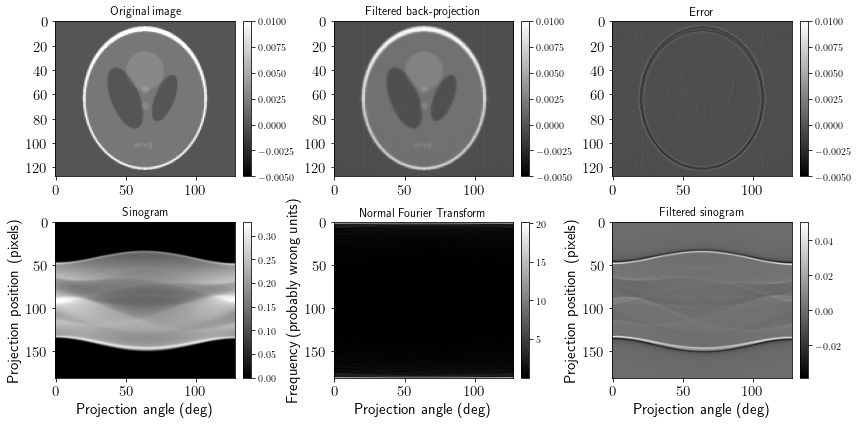

Error norm: 0.06389372056354718


In [12]:
# Make the plots.
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
plt.rcParams.update({'font.size': 10})

# First row:
show_image(               axs[0, 0], "Original image", img)
show_image(               axs[0, 1], "Filtered back-projection", reconstruction)
show_image(               axs[0, 2], "Error", error)

# Second row:
show_sinogram(            axs[1, 0], "Sinogram", sinogram)
show_transformed_sinogram(axs[1, 1], title_str, transformed_sinogram)
show_sinogram(            axs[1, 2], "Filtered sinogram", filtered_sinogram)

fig.tight_layout()
plt.show()

print(f"Error norm: {np.linalg.norm(error)}")

# Researching the effect of various windows on the FT of a sinogram

In [13]:
def plot_reconstruction_error_by_epss(transformed_sinogram, G, 
                                      filter_name, epss):
    """
    Draws a plot of the reconstruction error of FBP using the filter G
    """
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"],
        "font.size": 16})
    
    n = len(epss)
    num_cols = 4
    num_rows = (n + num_cols - 1) // num_cols
    
    reconstructions = [0 for _ in epss]
    errors = [0 for _ in epss]
    error_norms = [0 for _ in epss]
    
    for idx, eps in enumerate(epss):
        copied_fft = transformed_sinogram.copy()

        # Apply the Ramp filter
        height, width = copied_fft.shape
        for i in range(width):
            copied_fft[:, i] *= G(2 * np.fft.fftfreq(sinogram.shape[0]),
                                  eps)

        # Back to the sensor domain
        filtered_sinogram = np.fft.ifft(copied_fft, axis=0)
        assert np.isclose(filtered_sinogram.imag, 0).all()
        filtered_sinogram = filtered_sinogram.real

        # Compute the reconstruction
        reconstruction = iradon(filtered_sinogram, theta=theta, 
                                filter_name=None, circle=False)
        
        reconstructions[idx] = reconstruction
        # Compute the error
        error = reconstruction - img
        
        errors[idx] = error
        error_norms[idx] = np.linalg.norm(error)
        
    fig, axs = plt.subplots(n//4, 4, figsize=(num_cols * 4, num_rows * 4))
    print(f"Figsize: {(num_rows * 4, num_cols * 4)}")
        
    for idx, (eps, ax) in enumerate(zip(epss, fig.axes)):
        img_reconstruction = ax.imshow(reconstructions[idx], 
                                       aspect='auto',
#                                      vmin=-0.01, vmax=0.02
                                       )  
        
        # ax.set_title(f"$\log_{{10}}(\epsilon): {np.round(np.log10(eps), 2)}$")
        ax.set_title(f"$\epsilon = {np.round(eps, 2)}$")
        
        # Set up the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(img_reconstruction, cax=cax)
        
    plt.tight_layout()
    plt.savefig('ramlak-filter-on-noisy-phantom.png')
    plt.show()

    plt.title(f"Reconstruction error for {filter_name} filter")
    plt.xlabel("$\epsilon$")
    plt.ylabel(r"$\Vert \mu - FBP[R[\mu]] \Vert$")
    plt.plot(epss, error_norms)
    

Figsize: (8, 16)


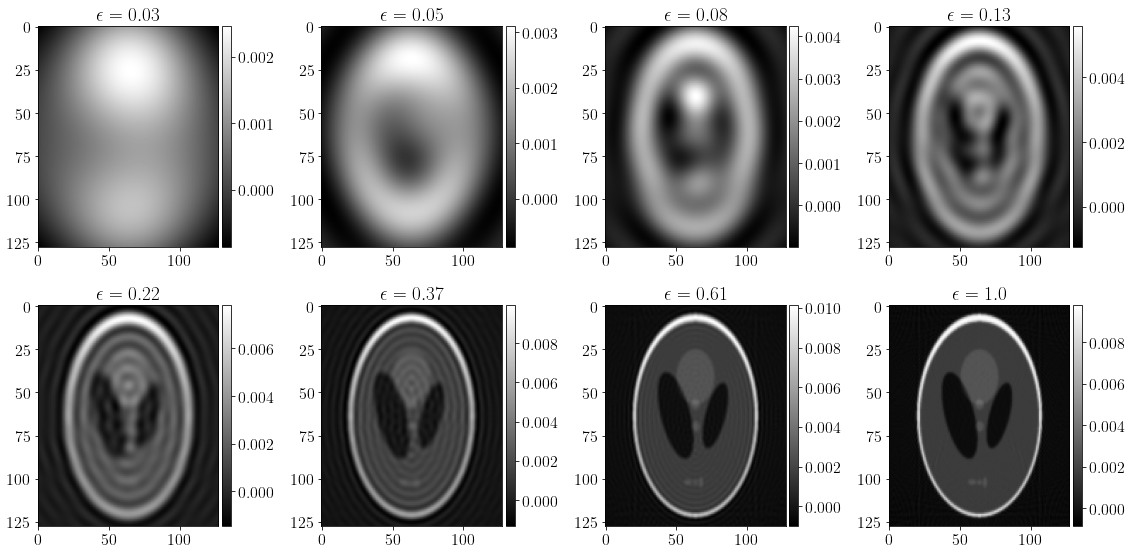

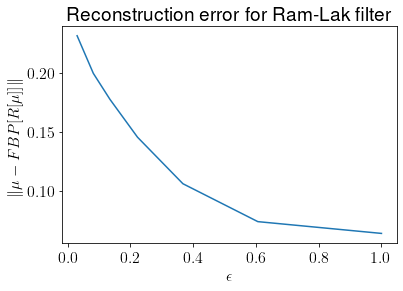

In [14]:
epss = np.logspace(np.log10(0.03), np.log10(1), 8)
plot_reconstruction_error_by_epss(transformed_sinogram, G_ram_lak, "Ram-Lak", epss)

# Plotting error norms for images in the shapes dataset

In [151]:
I_0_list = np.logspace(2, 5, 25)
G_list = [G_ram_lak, G_cosine_t, G_cosine_s, G_shepp_logan_t, G_shepp_logan_s]
# G_list = [G_ram_lak, G_cosine_t]
epss = np.logspace(np.log10(0.02), np.log10(1), 100)
# epss = np.logspace(np.log10(0.02), np.log10(1), 2)

num_images = 16

# The indices to error_norms are: image, I_0, G, eps
error_norms = np.zeros((num_images, len(I_0_list), 
                        len(G_list), len(epss)), dtype=float)

starting_time = time()

num_done = 0
num_left = num_images * len(I_0_list)

for i in range(num_images):
    # The first step is the same, regardless of I_0, G, and epss.
    # Namely: compute the Radon Transform of the image.
    img = shapes_dataset[i][0][0]
    
    # Perform the Radon Transformation
    theta = np.linspace(0, 180, max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)
    
    for j, I_0 in enumerate(I_0_list):
        print(f"Working on image {i+1}/{num_images}, noise level {j+1}/{len(I_0_list)}\t\t\t\t\t", end="\r")
        
        # The next step depends on only the image and I_0.
        # Namely: add noise to the image according to I_0, and
        # do an FFT.
        noisy_sinogram = add_sinogram_noise(sinogram, I_0=I_0)

        # Compute the Fourier Transform of the sinogram
        transformed_sinogram = np.fft.fft(noisy_sinogram, axis=0)

        for k, G in enumerate(G_list):
            for l, eps in enumerate(epss):
                # The last steps depend on the image, I_0, the filter, and
                # eps. Namely: apply the low-pass filter and compute the
                # error norm. 
                filtered_transformed_sinogram = transformed_sinogram.copy()

                height, width = filtered_transformed_sinogram.shape
                for col in range(width):
                    filtered_transformed_sinogram[:, col] *= \
                        G(2 * np.fft.fftfreq(sinogram.shape[0]), eps)

                # Back to the sensor domain
                filtered_sinogram = np.fft.ifft(filtered_transformed_sinogram, axis=0)
                assert np.isclose(filtered_sinogram.imag, 0).all()
                filtered_sinogram = filtered_sinogram.real

                # Compute the reconstruction
                reconstruction = iradon(filtered_sinogram, theta=theta, 
                                        filter_name=None, circle=False)

                # Compute the error
                error = reconstruction - img

                error_norms[i, j, k, l] = np.linalg.norm(error)

        num_done += 1
        num_left -= 1
        
        sleep(15)
        print(f"Image {i+1}/{num_images}, noise level {j+1}/{len(I_0_list)} done.\
, expected time left: {num_left / num_done * (time() - starting_time) / 60:0.2f} minutes.", end="\r")

# Save the results of the previous cell to a file
It took a lot of time, after all...

In [152]:
np.savez(f'error-norms-{time()}.npz', I_0_list=I_0_list, G_list=G_list, epss=epss, error_norms=error_norms)

## Checking that it worked

In [15]:
npzfile = np.load("error-norms-1655843796.2342718.npz")
error_norms = npzfile['error_norms']
I_0_list = npzfile['I_0_list']
G_list = [G_ram_lak, G_cosine_t, G_cosine_s, G_shepp_logan_t, G_shepp_logan_s]
epss = npzfile['epss']

# Plot the results

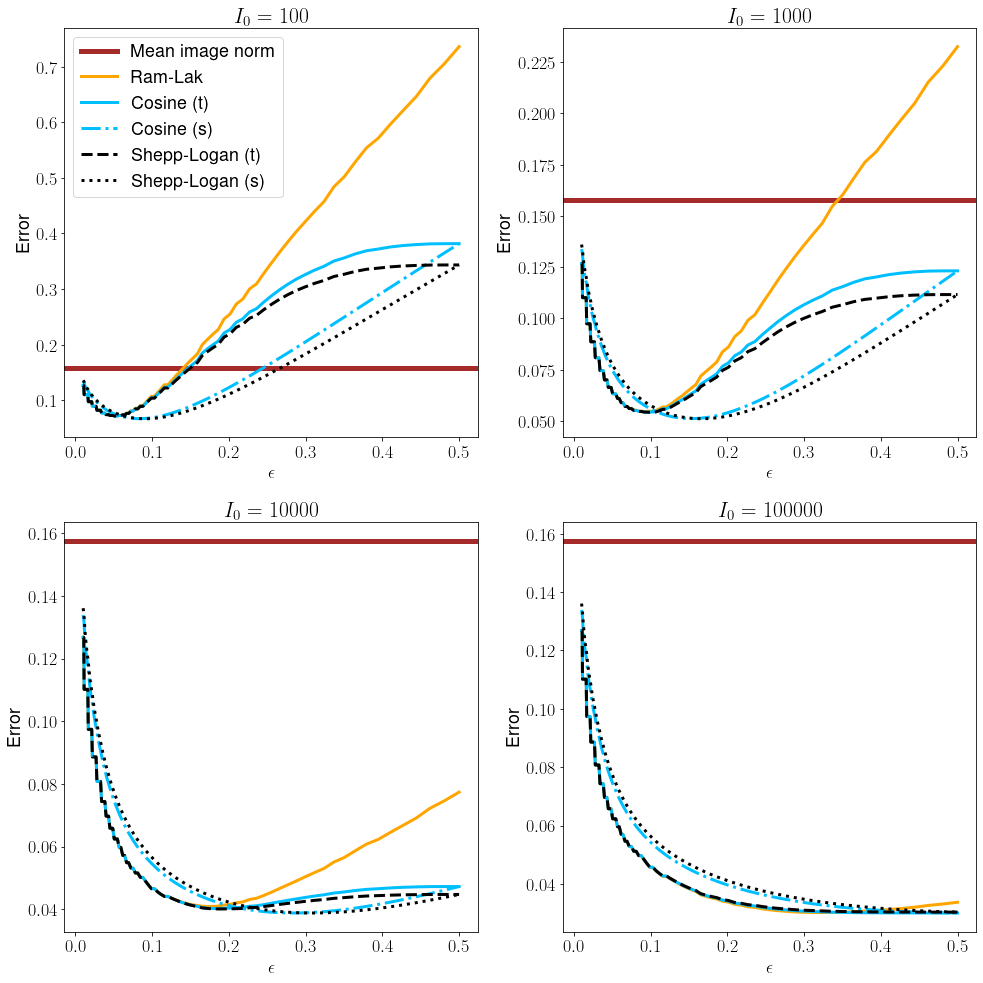

In [16]:
plt.rcParams.update({"text.usetex": True, "font.size": 18})

fig, axs = plt.subplots(2, 2, figsize=(14, 14))

for j, ax in zip([0, 8, 16, 24], axs.flat):
    for k, (G, name, style, color) in enumerate(
            zip(G_list, name_list[1:], style_list[1:], color_list[1:])):
        ax.errorbar(epss / 2, error_norms[:, j, k, :].mean(axis=0), 
                    label=name, ls=style, c=color, lw=3)

    # The reconstruction error for the image that is 0 everywhere
    ax.axhline(y=mean_norm, label="Mean image norm", c="brown", lw=5)
    
    ax.set_title(f"$I_0 = {I_0_list[j]:0.0f}$")
    ax.set_xlabel("$\epsilon$")
    ax.set_ylabel("Error")
    
    if j == 0:
        ax.legend()
        
fig.tight_layout()
plt.savefig('filter-errors.png')

In [173]:
np.argmin(error_norms.mean(axis=0), axis=2)

array([[41, 41, 54, 41, 56],
       [44, 44, 56, 44, 58],
       [44, 46, 57, 46, 60],
       [48, 48, 60, 48, 62],
       [48, 48, 61, 48, 64],
       [50, 50, 63, 50, 65],
       [52, 52, 65, 52, 68],
       [54, 54, 67, 54, 69],
       [56, 58, 69, 58, 71],
       [60, 60, 71, 60, 73],
       [60, 61, 73, 61, 75],
       [61, 64, 75, 64, 77],
       [64, 66, 77, 66, 79],
       [67, 68, 79, 69, 81],
       [69, 70, 81, 71, 83],
       [70, 72, 83, 72, 85],
       [72, 74, 85, 74, 87],
       [74, 77, 87, 77, 89],
       [76, 79, 89, 81, 91],
       [78, 82, 91, 83, 93],
       [81, 85, 93, 86, 95],
       [82, 87, 94, 90, 97],
       [84, 91, 96, 99, 99],
       [86, 99, 98, 99, 99],
       [88, 99, 99, 99, 99]])

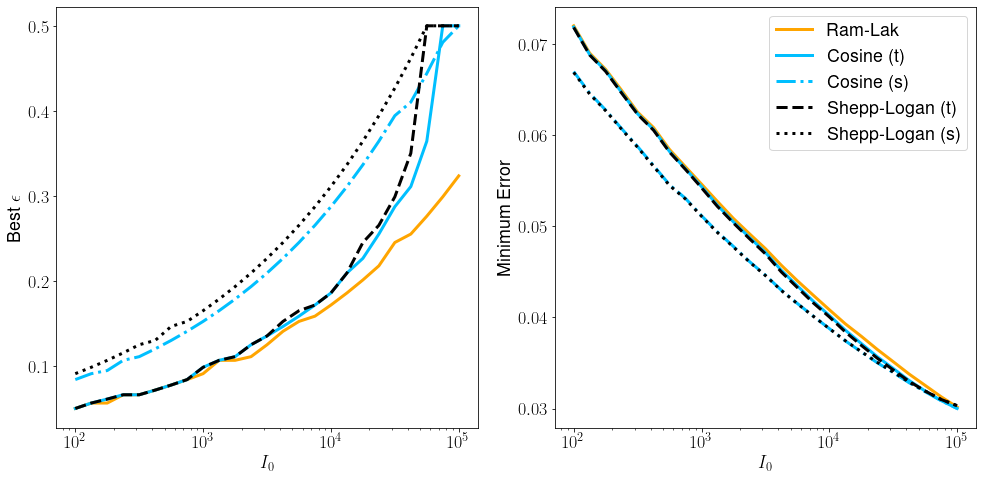

In [17]:
minimum_epss = epss[np.argmin(error_norms.mean(axis=0), axis=2)]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for k, (G, name, style, color) in enumerate(zip(G_list, name_list[1:], style_list[1:], color_list[1:])):
    axs[0].plot(I_0_list, minimum_epss[:, k] / 2, label=name, ls=style, c=color, lw=3)
    
axs[0].set_xscale('log')
axs[0].set_xlabel('$I_0$')
axs[0].set_ylabel('Best $\epsilon$')

for k, (G, name, style, color) in enumerate(zip(G_list, name_list[1:], style_list[1:], color_list[1:])):
    axs[1].plot(I_0_list, np.min(error_norms.mean(axis=0), axis=2)[:, k], label=name, ls=style, c=color, lw=3)
    
axs[1].set_xscale('log')
axs[1].set_xlabel('$I_0$')
axs[1].set_ylabel('Minimum Error')
axs[1].legend()

plt.tight_layout()
plt.savefig('minimum-error.png')

# Conclusion: recommendations

In [175]:
for j, I_0 in enumerate(I_0_list):
    mean_errors = error_norms[:, j, :, :].mean(axis=0)
    lowest_error = mean_errors.min()
    best_filter = mean_errors.argmin()
    G_idx, eps_idx = np.unravel_index(best_filter, (len(G_list), len(epss)))
    best_G, best_eps = name_list[1 + G_idx], epss[eps_idx]
    assert np.isclose(lowest_error, mean_errors[G_idx, eps_idx])
    print(f"For I_0 = {I_0:6.0f}, {best_G:15} with eps = {best_eps:0.2f} gives {lowest_error:0.3f}")

For I_0 =    100, Shepp-Logan (s) with eps = 0.18 gives 0.067
For I_0 =    133, Shepp-Logan (s) with eps = 0.20 gives 0.065
For I_0 =    178, Shepp-Logan (s) with eps = 0.21 gives 0.063
For I_0 =    237, Shepp-Logan (s) with eps = 0.23 gives 0.061
For I_0 =    316, Shepp-Logan (s) with eps = 0.25 gives 0.059
For I_0 =    422, Shepp-Logan (s) with eps = 0.26 gives 0.057
For I_0 =    562, Shepp-Logan (s) with eps = 0.29 gives 0.054
For I_0 =    750, Shepp-Logan (s) with eps = 0.31 gives 0.053
For I_0 =   1000, Shepp-Logan (s) with eps = 0.33 gives 0.051
For I_0 =   1334, Shepp-Logan (s) with eps = 0.36 gives 0.049
For I_0 =   1778, Shepp-Logan (s) with eps = 0.39 gives 0.048
For I_0 =   2371, Shepp-Logan (s) with eps = 0.42 gives 0.046
For I_0 =   3162, Shepp-Logan (s) with eps = 0.45 gives 0.045
For I_0 =   4217, Shepp-Logan (s) with eps = 0.49 gives 0.043
For I_0 =   5623, Shepp-Logan (s) with eps = 0.53 gives 0.042
For I_0 =   7499, Shepp-Logan (s) with eps = 0.58 gives 0.040
For I_0 

# Calculating FBP error for comparison

In [197]:
I_0_list = np.logspace(2, 5, 25)

num_images = 16

# The indices to error_norms are: image, I_0, G, eps
fbp_error_norms = np.zeros((num_images, len(I_0_list)), dtype=float)

starting_time = time()

num_done = 0
num_left = num_images * len(I_0_list)

for i in range(num_images):
    # The first step is the same, regardless of I_0, G, and epss.
    # Namely: compute the Radon Transform of the image.
    img = shapes_dataset[i][0][0]
    
    # Perform the Radon Transformation
    theta = np.linspace(0, 180, max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta, circle=False)
    
    for j, I_0 in enumerate(I_0_list):
        print(f"Working on image {i+1}/{num_images}, noise level {j+1}/{len(I_0_list)}\t\t\t\t\t", end="\r")
        
        # The next step depends on only the image and I_0.
        # Namely: add noise to the image according to I_0, and
        # do an FFT.
        noisy_sinogram = add_sinogram_noise(sinogram, I_0=I_0)

        # Compute the Fourier Transform of the sinogram
        transformed_sinogram = np.fft.fft(noisy_sinogram, axis=0)

        # The last steps depend on the image, I_0, the filter, and
        # eps. Namely: apply the low-pass filter and compute the
        # error norm. 
        filtered_transformed_sinogram = transformed_sinogram.copy()

        height, width = filtered_transformed_sinogram.shape
        for col in range(width):
            filtered_transformed_sinogram[:, col] *= \
                G_ramp(2 * np.fft.fftfreq(sinogram.shape[0]), eps)

        # Back to the sensor domain
        filtered_sinogram = np.fft.ifft(filtered_transformed_sinogram, axis=0)
        assert np.isclose(filtered_sinogram.imag, 0).all()
        filtered_sinogram = filtered_sinogram.real

        # Compute the reconstruction
        reconstruction = iradon(
                                filtered_sinogram, 
#                                 noisy_sinogram,
                                theta=theta, 
                                filter_name=None,
                                circle=False)

        # Compute the error
        error = reconstruction - img

        fbp_error_norms[i, j] = np.linalg.norm(error)

        num_done += 1
        num_left -= 1
        print(f"Image {i+1}/{num_images}, noise level {j+1}/{len(I_0_list)} done.\
, expected time left: {num_left / num_done * (time() - starting_time) / 60:0.2f} minutes.", end="\r")

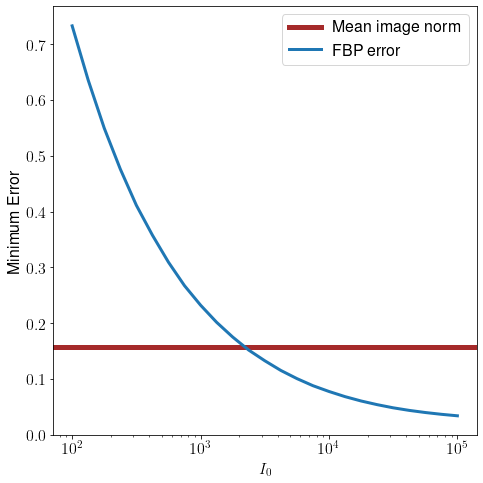

In [198]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.axhline(y=mean_norm, label="Mean image norm", c="brown", lw=5)
ax.plot(I_0_list, fbp_error_norms.mean(axis=0), lw=3, label="FBP error")

ax.set_xscale('log')
ax.set_xlabel('$I_0$')
ax.set_ylabel('Minimum Error')

ax.legend()
plt.tight_layout()
plt.savefig('fbp-reconstruction-error')

In [199]:
for j, I_0 in enumerate(I_0_list):
    mean_error = fbp_error_norms[:, j].mean(axis=0)
    print(f"For I_0 = {I_0:6.0f}, Ramp gives {mean_error:0.3f}")

For I_0 =    100, Ramp gives 0.733
For I_0 =    133, Ramp gives 0.635
For I_0 =    178, Ramp gives 0.549
For I_0 =    237, Ramp gives 0.476
For I_0 =    316, Ramp gives 0.411
For I_0 =    422, Ramp gives 0.358
For I_0 =    562, Ramp gives 0.309
For I_0 =    750, Ramp gives 0.267
For I_0 =   1000, Ramp gives 0.232
For I_0 =   1334, Ramp gives 0.201
For I_0 =   1778, Ramp gives 0.175
For I_0 =   2371, Ramp gives 0.152
For I_0 =   3162, Ramp gives 0.132
For I_0 =   4217, Ramp gives 0.115
For I_0 =   5623, Ramp gives 0.101
For I_0 =   7499, Ramp gives 0.088
For I_0 =  10000, Ramp gives 0.077
For I_0 =  13335, Ramp gives 0.068
For I_0 =  17783, Ramp gives 0.060
For I_0 =  23714, Ramp gives 0.054
For I_0 =  31623, Ramp gives 0.048
For I_0 =  42170, Ramp gives 0.043
For I_0 =  56234, Ramp gives 0.040
For I_0 =  74989, Ramp gives 0.036
For I_0 = 100000, Ramp gives 0.034


<function G_shepp_logan_s at 0x7f25e3c23ac0> 0.18283676707188942
<function G_shepp_logan_s at 0x7f25e3c23ac0> 0.3307373414399151
<function G_shepp_logan_s at 0x7f25e3c23ac0> 0.6223923441532677
<function G_cosine_t at 0x7f25e3c23d00> 1.0


/tmp/ipykernel_5357/3530149694.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


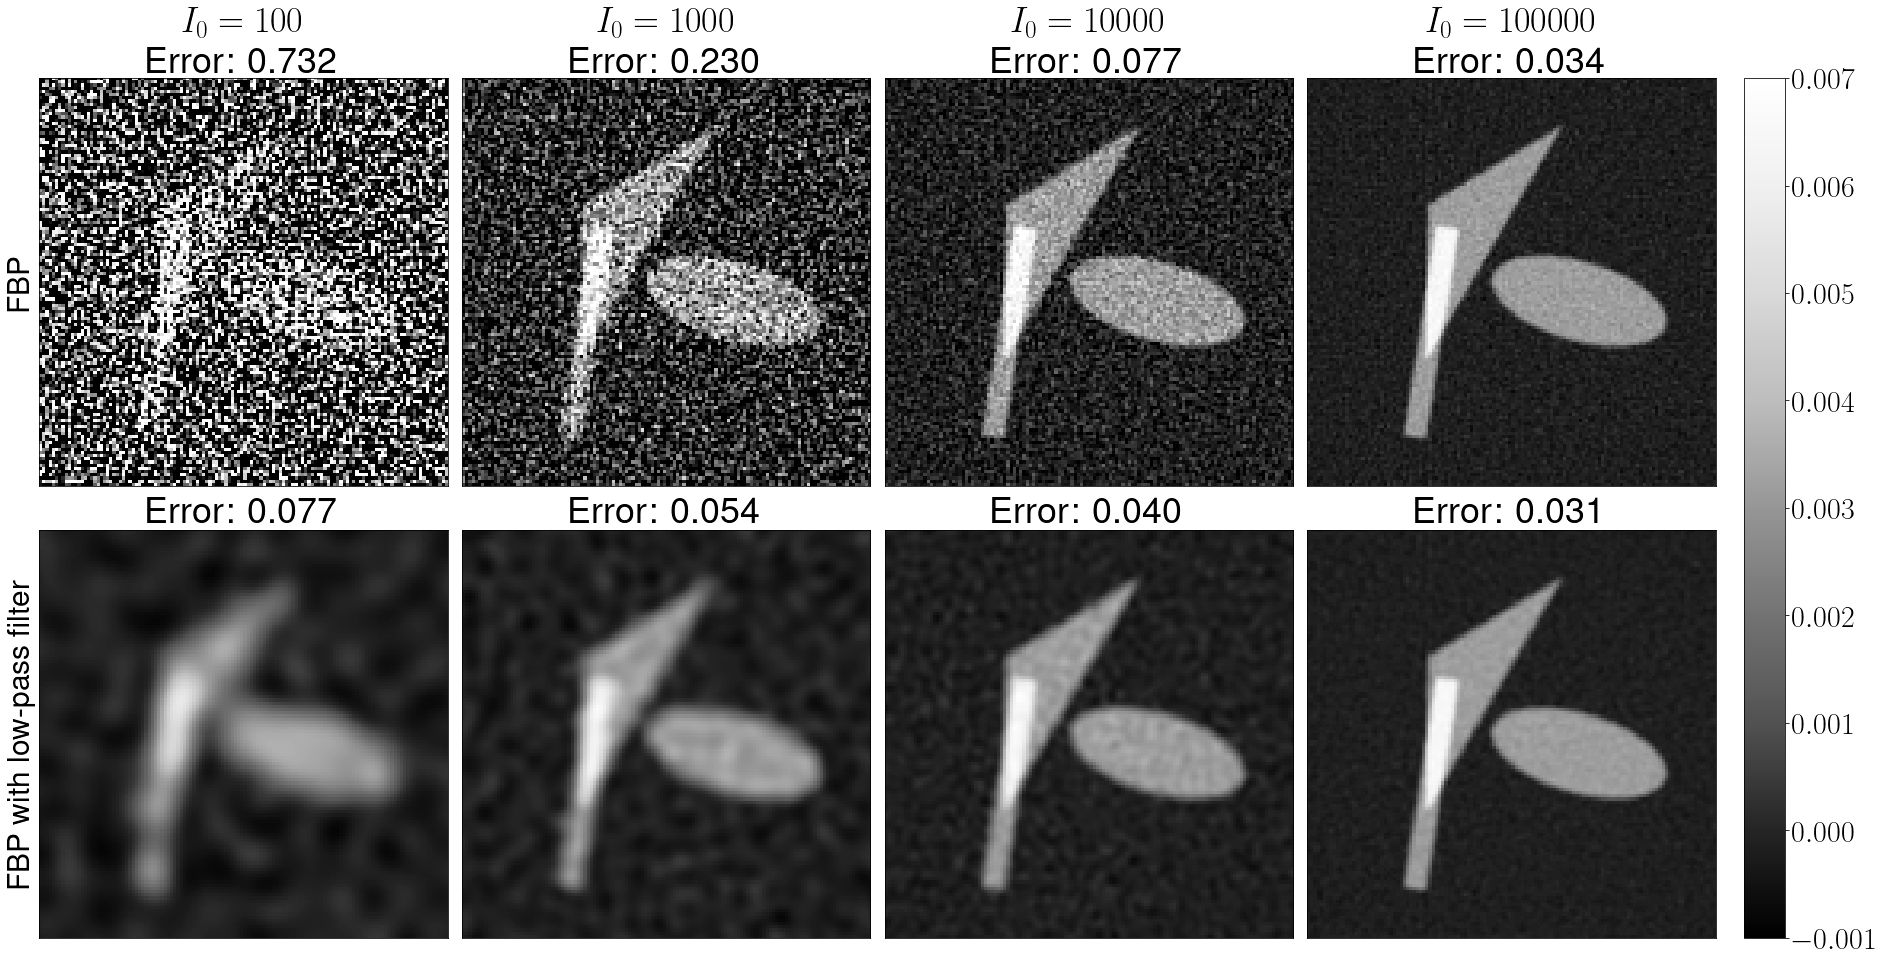

In [18]:
from radontools import add_scan_noise

from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams.update({'font.size': 30})

G_list = [G_ram_lak, G_cosine_t, G_cosine_s, G_shepp_logan_t, G_shepp_logan_s]
epss = np.logspace(np.log10(0.02), np.log10(1), 100)

fig = plt.figure(figsize=(28, 14))
grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,4),
                 axes_pad=(0.2, 0.6),
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.4,
                 )

shape_image = shape_dataset[62][0][0]
# Perform the Radon Transformation
theta = np.linspace(0, 180, max(shape_image.shape), endpoint=False)
sinogram = radon(shape_image, theta=theta, circle=False)

vmin, vmax = -0.001, 0.007

for j, ax0, ax1 in zip([0, 8, 16, 24], grid[:4], grid[4:]):
    I_0 = I_0_list[j]
    mean_errors = error_norms[:, j, :, :].mean(axis=0)
    best_filter = mean_errors.argmin()
    
    G_idx, eps_idx = np.unravel_index(best_filter, (len(G_list), len(epss)))
    G, eps = G_list[G_idx], epss[eps_idx]
    print(G, eps)
        
    # The next step depends on only the image and I_0.
    # Namely: add noise to the image according to I_0, and
    # do an FFT.
    noisy_sinogram = add_sinogram_noise(sinogram, I_0=I_0)

    # Calculate the regular FBP reconstruction
    fbp_reconstruction = add_scan_noise(shape_image, I_0=I_0) 
    
    fbp_error_norm = np.linalg.norm(fbp_reconstruction - shape_image)
    
    pltimg = ax0.imshow(fbp_reconstruction, cmap=plt.cm.Greys_r, vmin=vmin, vmax=vmax)
    
    ax0.set_title(f"Error: {fbp_error_norm:0.3f}")
    ax0.set_xticks([])
    ax0.set_yticks([])
    
    if j == 0:
        ax0.set_ylabel('FBP')
        
    ax0.annotate(f"$I_0 = {I_0:0.0f}$", xy=(0.5, 1.1), xytext=(0, 5),
                 xycoords='axes fraction', textcoords='offset points',
                 size='large', ha='center', va='baseline')
    
    # Compute the Fourier Transform of the sinogram
    transformed_sinogram = np.fft.fft(noisy_sinogram, axis=0)
    # The last steps depend on the image, I_0, the filter, and
    # eps. Namely: apply the low-pass filter and compute the
    # error norm. 
    filtered_transformed_sinogram = transformed_sinogram.copy()

    height, width = filtered_transformed_sinogram.shape
    for col in range(width):
        filtered_transformed_sinogram[:, col] *= \
            G(2 * np.fft.fftfreq(sinogram.shape[0]), eps)

    # Back to the sensor domain
    filtered_sinogram = np.fft.ifft(filtered_transformed_sinogram, axis=0)
    assert np.isclose(filtered_sinogram.imag, 0).all()
    filtered_sinogram = filtered_sinogram.real

    # Compute the reconstruction
    reconstruction = iradon(filtered_sinogram, theta=theta, 
                            filter_name=None, circle=False)

    # Compute the error
    error_norm = np.linalg.norm(reconstruction - shape_image)
    
    pltimg = ax1.imshow(reconstruction, 
                        cmap=plt.cm.Greys_r, 
                        vmin=vmin, vmax=vmax)
    
    ax1.set_title(f"Error: {error_norm:0.3f}")
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    if j == 0:
        ax1.set_ylabel('FBP with low-pass filter')

ax0.cax.colorbar(pltimg)
ax0.cax.toggle_label(True)
plt.tight_layout()

plt.savefig('fbp-and-lowpass-reconstructions.png')

# Some additional plots for the W voortgangspresentatie

Error norm: 0.49468419468691976


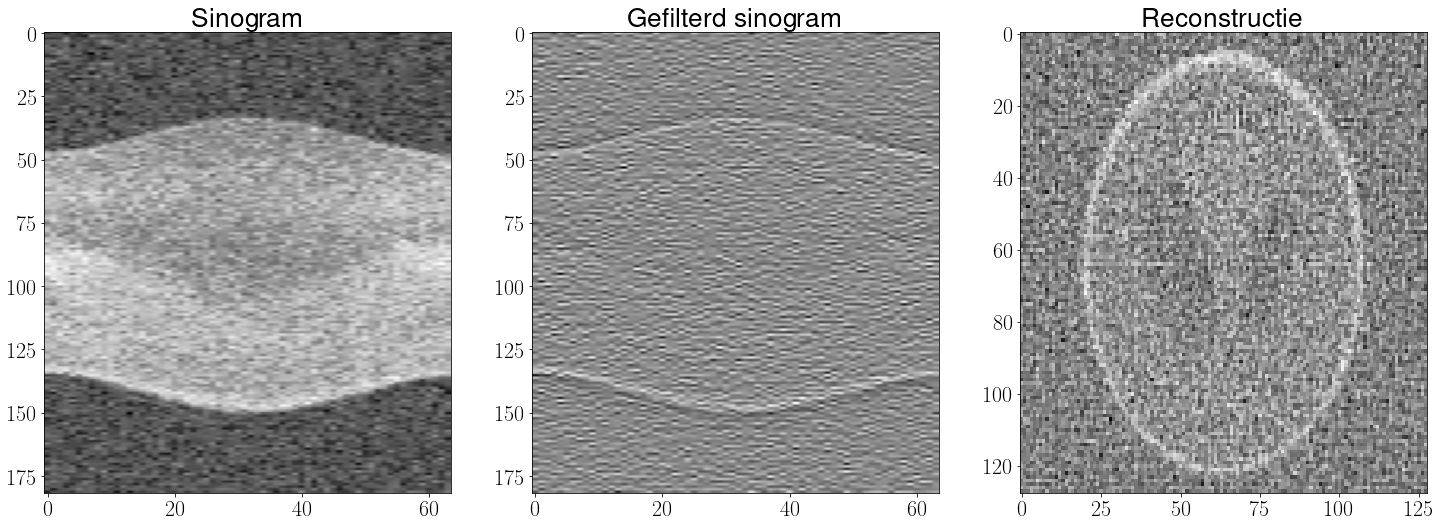

In [19]:
def show_sinogram(ax, title_str, sinogram):
    ax.set_title(title_str)
    
#     ax.set_xlabel("Hoek (graden)")
#     ax.set_ylabel("Positie (pixels)")
    img_sinogram = ax.imshow(sinogram,
                             aspect='auto')
#     plt.colorbar(img_sinogram, ax=ax, fraction=0.046, pad=0.04)

def show_image(ax, title_str, image):
    ax.set_title(title_str)
    img = ax.imshow(image, aspect='auto')
#     plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)    


plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(1,3, figsize=(24, 8))
# plt.axis('off')

# First row:
show_image(               axs[2], "Reconstructie", reconstruction)

# Second row:
show_sinogram(            axs[0], "Sinogram", sinogram)
show_sinogram(            axs[1], "Gefilterd sinogram", filtered_sinogram)

fig.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)
plt.savefig('fbp-example-noisy.png')

print(f"Error norm: {np.linalg.norm(error)}")

Error norm: 0.49468419468691976


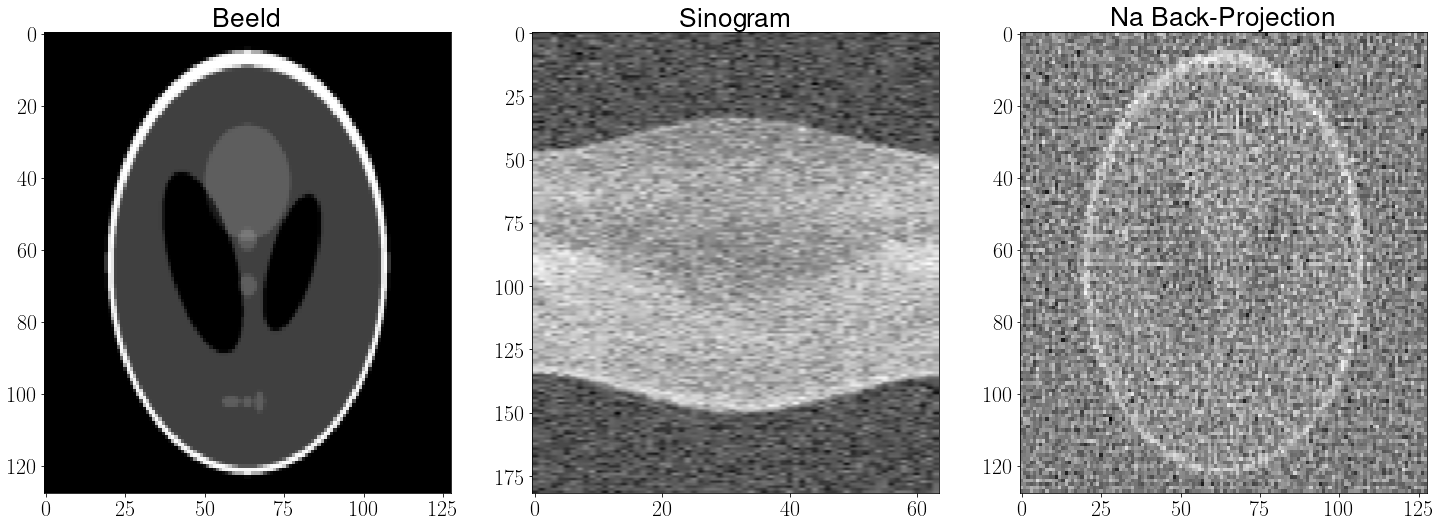

In [20]:
def show_sinogram(ax, title_str, sinogram):
    ax.set_title(title_str)
    
#     ax.set_xlabel("Hoek (graden)")
#     ax.set_ylabel("Positie (pixels)")
    img_sinogram = ax.imshow(sinogram, 
                             aspect='auto')
#     plt.colorbar(img_sinogram, ax=ax, fraction=0.046, pad=0.04)

def show_image(ax, title_str, image):
    ax.set_title(title_str)
    img = ax.imshow(image, aspect='auto')
#     plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)    


plt.rcParams.update({'font.size': 22})

fig, axs = plt.subplots(1,3, figsize=(24, 8))
# plt.axis('off')

# First row:
show_image(               axs[0], "Beeld", img)

# Second row:
show_sinogram(            axs[1], "Sinogram", sinogram)
show_image(               axs[2], "Na Back-Projection", reconstruction)

fig.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)
plt.savefig('backprojection-no-filter.png')

print(f"Error norm: {np.linalg.norm(error)}")

# Additional plots for W eindpresentatie

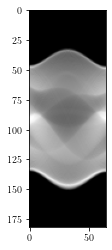

In [21]:
plt.imshow(sinogram)

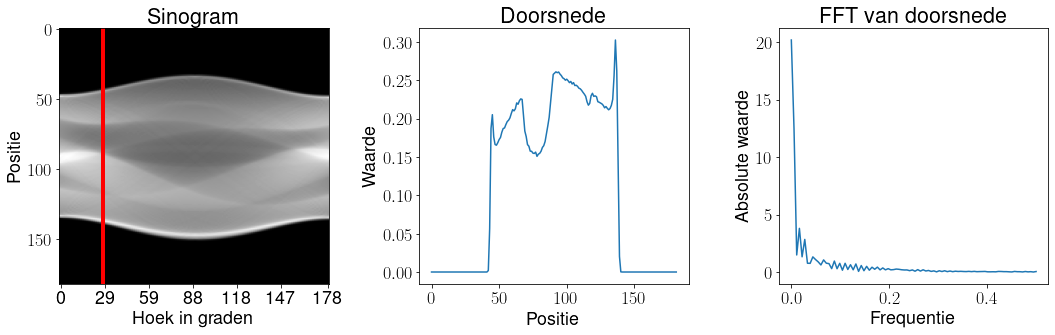

In [53]:
def make_fft_plot(sinogram, filtered=False, cutoff=-1):
    plt.rcParams.update({"text.usetex": True, "font.size": 18})

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    x_section = 20

    axs[0].set_title('Sinogram')
    axs[0].set_xlabel('Hoek in graden')

    xticks = np.linspace(0, len(theta) - 1, 7, dtype=int)
    labels = theta[xticks].astype(int)
    axs[0].set_xticks(xticks)
    axs[0].set_xticklabels(labels)

    axs[0].set_ylabel('Positie')
    axs[0].axvline(x=x_section, lw=4, c='red')

    sinogram_slice = sinogram[:, x_section]

    transformed_sinogram_slice = np.fft.rfft(sinogram_slice)
    freqs = np.fft.rfftfreq(len(sinogram_slice))
    
    if filtered:
        transformed_sinogram_slice[freqs > cutoff] = 0
        sinogram_slice = np.fft.irfft(transformed_sinogram_slice)
        closest_value = freqs[np.argmin((freqs - cutoff)**2)]
        axs[2].axvline(x=closest_value, lw=1, c='black')
        axs[2].set_title('FFT van doorsnede (gefilterd)')
        axs[1].set_title('Doornsede (gefilterd)')
        
        transformed_sinogram = np.fft.rfft(sinogram, axis=0)
        transformed_sinogram[freqs > cutoff, :] = 0
        filtered_sinogram = np.fft.irfft(transformed_sinogram, axis=0)
        axs[0].imshow(filtered_sinogram, aspect='auto')
        axs[0].set_title('Sinogram (gefilterd)')
        
    else:
        axs[2].set_title('FFT van doorsnede')
        axs[1].set_title('Doorsnede')
        axs[0].imshow(sinogram, aspect='auto')
        
    axs[1].plot(sinogram_slice)
    axs[1].set_xlabel('Positie')
    axs[1].set_ylabel('Waarde')
    
    axs[2].plot(np.fft.rfftfreq(len(sinogram_slice)), abs(transformed_sinogram_slice))
    
    axs[2].set_xlabel('Frequentie')
    axs[2].set_ylabel('Absolute waarde')

    plt.tight_layout()
    
make_fft_plot(sinogram)
plt.savefig('sinogram-fft.png')

In [16]:
noisy_sinogram = add_sinogram_noise(sinogram, I_0=10**2)

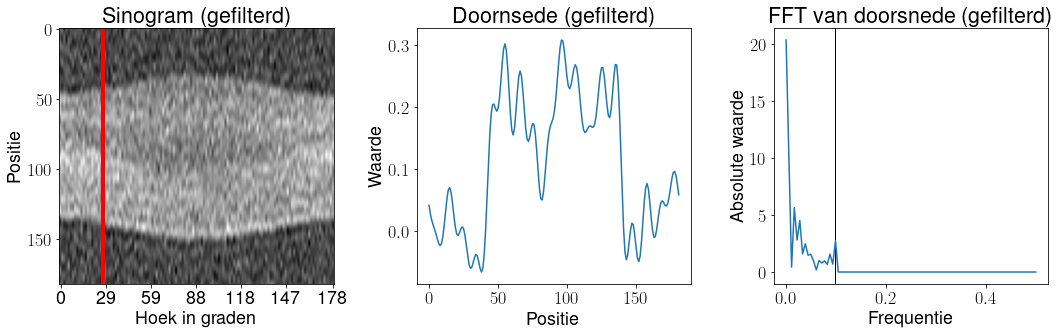

In [55]:
make_fft_plot(noisy_sinogram, filtered=True, cutoff=0.1)
plt.savefig('noisy-sinogram-fft-filtered.png')

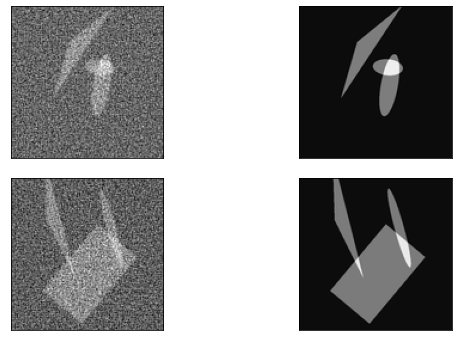

In [117]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

for i in range(2):
    true_image = shapes_dataset[i+10][0][0]
    noisy_image = shapes_dataset[i+10][1][0]
    
    axs[i, 0].imshow(noisy_image)
    axs[i, 1].imshow(true_image)
    
    axs[i, 0].set_xticks([])
    axs[i, 0].set_yticks([])
    axs[i, 1].set_xticks([])
    axs[i, 1].set_yticks([])
    
plt.tight_layout()

plt.savefig('noisy-and-true.png')

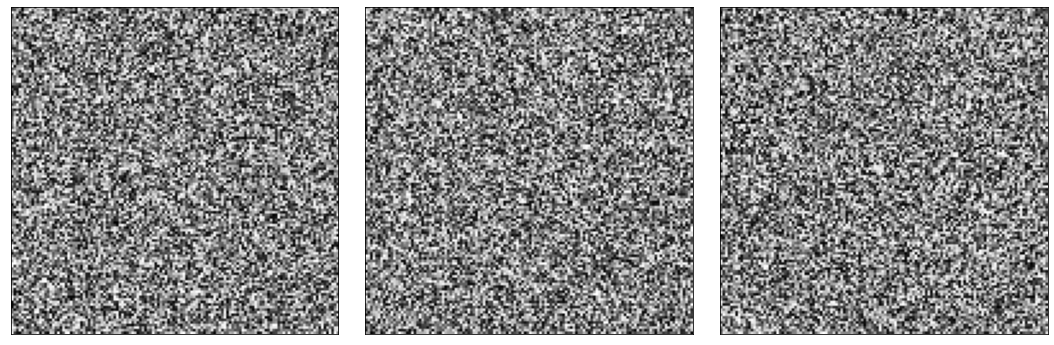

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for ax in axs:
    ax.imshow(np.random.random((128, 128)))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()

plt.savefig('random-images.png')